In [1]:
import pandas as pd
from graphviz import Graph
from skimage.io import imread, imshow
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv', encoding='cp1251', delimiter = ";", index_col="№ страхового события")
data = data[["Участник 1", "Участник 2"]]
data.head()

,Участник 1,Участник 2
№ страхового события,,
1,Беляев Владислав Аркадьевич,Ефимов Малик Константинович
2,Давыдова Ануш Оскаровна,Никифорова Божена Львовна
3,Белов Сергей Михайлович,Третьяков Никита Харитонович
4,Власов Артём Михайлович,Аксенова Вероника Кузьминична
5,Яковлев Алан Макарович,Сысоев Елисей Тимофеевич


Собственно говоря у нас имеются только имена участников. Как понять, кто из них мошенник - не знаю. Единственная моя догадка, это то, что мошенники часто попадают в ДТП

In [3]:
data.shape

(261, 2)

In [4]:
data['Участник 1'].nunique()

256

In [5]:
data['Участник 2'].nunique()

258

In [6]:
data['Участник 1'].value_counts()[:4]

Дорофеева Гулия Николаевна         3
Котова Виктория Архиповна          2
Мухамадеев Александр Валерьевич    2
Стрелков Евгений Егорович          2
Name: Участник 1, dtype: int64

In [7]:
data['Участник 2'].value_counts()[:3]

Сенчукова Екатерина Семеновна    2
Мамонтов Мстислав Георгиевич     2
Дорофеева Гулия Николаевна       2
Name: Участник 2, dtype: int64

Дорофеева точно ведёт себя крайне странно. Возможно ещё следует в целом посмотреть на пересечения двух массивов

In [8]:
all_people = pd.concat([data['Участник 1'], data['Участник 2']])

In [9]:
all_people.value_counts()[:11]

Дорофеева Гулия Николаевна         5
Мамонтов Мстислав Георгиевич       3
Котова Виктория Архиповна          3
Стрелков Евгений Егорович          2
Мухамадеев Александр Валерьевич    2
Коробов Вадим Александрович        2
Воробьев Иван Александрович        2
Сенчукова Екатерина Семеновна      2
Комин Сергей Николаевич            2
Павлова Мария Геннадиевна          2
Рогачев Антон Владимирович         2
dtype: int64

Котова и Мамонтов тоже могут быть жуликами. И последнее предположение которое у меня есть: друзья жуликов - жулики

In [10]:
cheater = set(["Дорофеева Гулия Николаевна", "Котова Виктория Архиповна", "Мамонтов Мстислав Георгиевич"])

In [11]:
num = 0
while len(cheater) > num:
    num = len(cheater)
    for person in data.values:
        if person[0] in cheater:
            cheater.add(person[1])
        if person[1] in cheater:
            cheater.add(person[0])
print(cheater)

{'Галкина Елена Тарасовна', 'Петухова Медина Максимовна', 'Пахомов Анатолий Васильевич', 'Архипова Анна Игоревна', 'Котова Виктория Архиповна', 'Миронов Пётр Александрович', 'Суворов Илья Макарович', 'Шубин Всеволод Валерьевич', 'Елисеева Сати Вячеславовна', 'Федотов Ростислав Богуславович', 'Королева Радмила Олеговна', 'Мамонтов Мстислав Георгиевич', 'Цветков Валерий Ростиславович', 'Дорофеева Гулия Николаевна'}


В итоге можно сказать, что у нас есть 3 почти 100% мошенников  и всего 14 людей, которые могли жульничать. Какой из этого всего можно сделать вывод. Нам важны люди, у которых большое число связей и все их связи(а ещё связи связи связей и т.д.) По сути мы занимаемся кластеризацией.
А говоря математическим языком мы ищем компоненты связности в графе. К сожалению я не пользовался алгоритмами связанными с этим ранее.
Если бы выборка была большой, то наверное пришлось бы строить бы строить матрицу смежности. И работать с ней.
<a href="https://habrahabr.ru/post/112421/">Статья про графы в питоне</a>

Теперь стоит задача в генерализации решения. Каким образом искать компоненты связности. Выше я писал про матрицу смежности, но тут она будет бесполезна, потому что у неё очень большие размеры, а информации несёт очень мало, она является спарс матрицей.
<br>Поэтому теперь мы будем пользоваться алгоритмом слияния. Изначально у нас есть вершины графа - их около 500 штук. Все они не соединены друг с другом. Затем у нас есть 261 запись о связях между ними. Те вершины, которые свяны стоит объединить в одно подмножество. После прохода по списку связей у нас получатся компоненты связности. Если размер компоненты больше 2(3), то она будет подозрительной, как и все люди, входящие в неё.
<br>Однако не только количество вершин важно, важно и число рёбер внутри этой компоненты.
<br>Получается что класс компоненты должен быть таким: у него должны быть аттрибуты мн-во вершин, входящих в него. число рёбер. А также должны быть две операции - добавление ребра и слияние двух компонент.

In [12]:
class Component:
      
    def __init__(self, vertex):
        self.vertex_set = {vertex}
        self.n_edges = 0
        
    def add(self, component):
        self.vertex_set.update(component.vertex_set)
        self.n_edges += component.n_edges + 1
        
    def add_edge(self):
        self.n_edges += 1

После того, как мы создали класс <i>компонента</i>, теперь надо подумать как эти компоненты хранить и как добавлять туда рёбра. Наверное будем хранить их в списке, итерироваться по списку происшедствий, искать в списке компонент нужные нам и мёрджить их. А лишние выкидывать из списка.

Создадим список участников и первоначальные компоненты.

In [15]:
components = []
for person in all_people.unique():
    components.append(Component(person))

In [16]:
for crash in data.values:
    for cmpt in components:
        if crash[0] in cmpt.vertex_set:
            if crash[1] in cmpt.vertex_set:
                cmpt.add_edge()
            else:
                for cmpt_ in components:
                    if crash[1] in cmpt_.vertex_set:
                        cmpt.add(cmpt_)
                        components.remove(cmpt_)
                        break

In [17]:
cheaters = set()
strange_components = []
for cmpt in components:
    if cmpt.n_edges>2:
        cheaters.update(cmpt.vertex_set)
        strange_components.append(cmpt)
cheaters

{'Архипова Анна Игоревна',
 'Воробьев Иван Александрович',
 'Галкина Елена Тарасовна',
 'Дорофеева Гулия Николаевна',
 'Елисеева Сати Вячеславовна',
 'Комин Сергей Николаевич',
 'Коробов Вадим Александрович',
 'Королева Радмила Олеговна',
 'Котова Виктория Архиповна',
 'Мамонтов Мстислав Георгиевич',
 'Миронов Пётр Александрович',
 'Мухамадеев Александр Валерьевич',
 'Павлова Мария Геннадиевна',
 'Пахомов Анатолий Васильевич',
 'Петухова Медина Максимовна',
 'Рогачев Антон Владимирович',
 'Сенчукова Екатерина Семеновна',
 'Суворов Илья Макарович',
 'Федотов Ростислав Богуславович',
 'Цветков Валерий Ростиславович',
 'Шубин Всеволод Валерьевич'}

Также эти подозрительные компоненты можно визаулизировать. Я хотел чтобы был виден весь граф, однако Graphviz рисовал всё в строку и было не наглядно

In [18]:
i = 1
for cmpt in strange_components:
    g = Graph(name='Car Accidents', filename="graph{}.gv".format(i), format='png')
    g.node_attr.update(color='lightblue1', style='filled')
    for crash in data.values:
        if crash[0] in cmpt.vertex_set:
            g.edge(crash[0], crash[1])
    i += 1

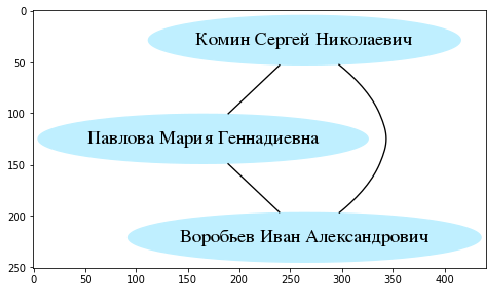

In [19]:
image = imread('graph1.gv.png')
plt.figure(figsize=(7,7))
imshow(image)

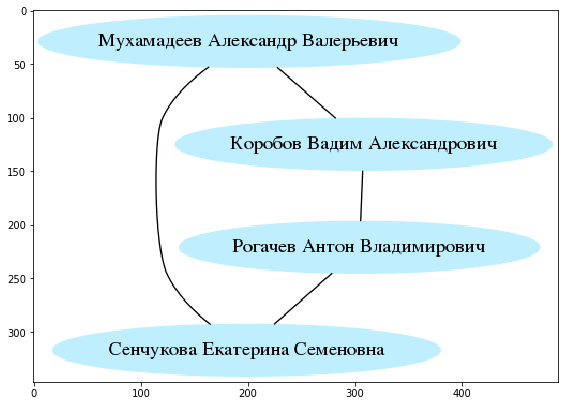

In [20]:
image = imread('graph2.gv.png')
plt.figure(figsize=(8,8))
imshow(image)

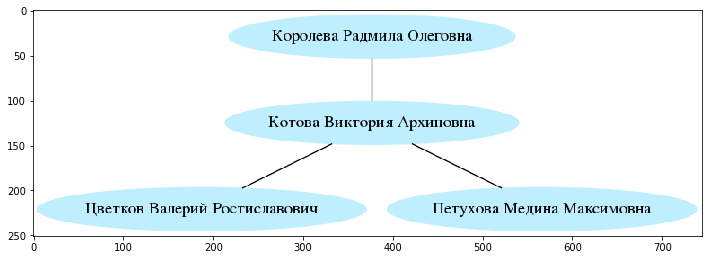

In [21]:
image = imread('graph3.gv.png')
plt.figure(figsize=(10,10))
imshow(image)

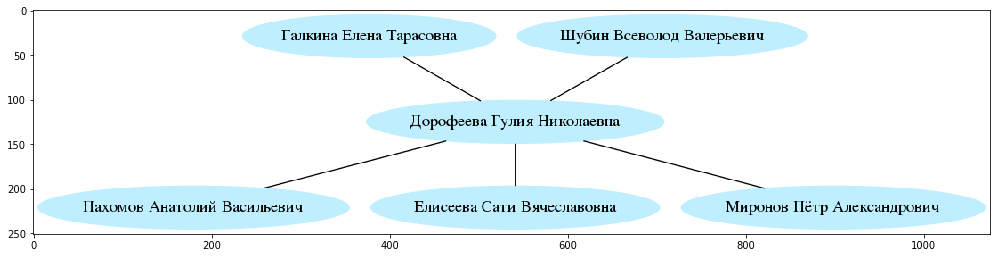

In [22]:
image = imread('graph4.gv.png')
plt.figure(figsize=(14,14))
imshow(image)

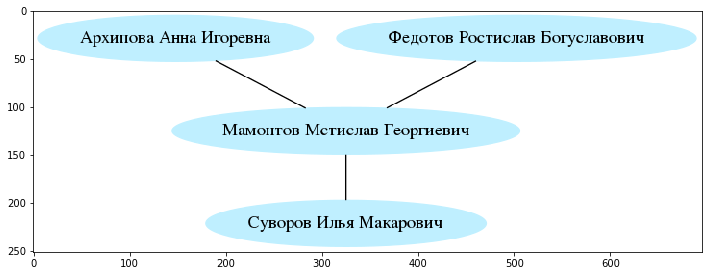

In [23]:
image = imread('graph5.gv.png')
plt.figure(figsize=(10,10))
imshow(image)